In [143]:
import pandas as pd

In [144]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
import numpy as np
import matplotlib.pyplot as plt

df_final_clean = pd.read_excel("df_final_clean.xlsx")
df_final_clean_encoded = df_final_clean.copy()

# ✅ 3. แปลง categorical เป็นตัวเลข (ถ้ามี)
for col in df_final_clean_encoded.select_dtypes(include=['object', 'category']).columns:
    le = LabelEncoder()
    df_final_clean_encoded[col] = le.fit_transform(df_final_clean_encoded[col]).astype(int)

df_final_clean_encoded = df_final_clean_encoded.drop(columns=['date'])
df_final_clean_encoded

,cases,temp_15d_avg,rain_15d_avg,humid_15d_avg,อายุ(ปี),เพศ,อาชีพ,ตำบล,อำเภอ,เดือน,ปี,ไตรมาส,ฤดูกาล
0,1,22.745000,0.000000,74.794444,34.0,0,0,8,1,2,2017,1,2
1,1,27.170000,2.386667,74.827333,13.0,0,10,60,8,4,2017,2,1
2,1,27.786667,2.520000,73.410667,51.0,1,0,60,8,5,2017,2,1
3,1,27.970000,4.253333,73.302667,14.0,1,10,60,8,5,2017,2,1
4,2,28.501333,4.233333,73.984667,58.0,0,9,60,8,5,2017,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1045,2,22.858571,2.071429,82.036429,20.5,1,6,3,2,12,2024,4,2
1046,2,22.716667,1.933333,81.784000,56.0,0,7,31,2,12,2024,4,2
1047,1,21.687333,1.933333,82.676000,11.0,1,10,15,2,12,2024,4,2
1048,1,21.304667,1.933333,82.992667,41.0,1,7,35,6,12,2024,4,2


In [145]:
df_final_clean_encoded.corr()['cases'] #ก่อนเพิ่มหลังจากเอนโค๊ด

cases            1.000000
temp_15d_avg     0.100030
rain_15d_avg     0.094145
humid_15d_avg    0.018460
อายุ(ปี)        -0.034136
เพศ              0.007874
อาชีพ            0.088724
ตำบล             0.051749
อำเภอ            0.042857
เดือน           -0.005328
ปี               0.229528
ไตรมาส           0.013666
ฤดูกาล          -0.147233
Name: cases, dtype: float64

## Phase1.เริ่มจากข้อมูลดิบ ไม่มีอะไรเลย ##


In [146]:
# เป้าหมาย: พิสูจน์ปี Train/Test ที่เหมาะสุด ด้วย Walk-Forward
# =========================================
import warnings; warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

SEED = 42

def safe_mape(y_true, y_pred, eps=1.0):
    # MAPE แบบกันหารศูนย์: ใช้ |(y - yhat)/(y + eps)|
    return 100.0 * np.mean(np.abs((y_true - y_pred) / (np.abs(y_true) + eps)))

# ---------- 1) Load + Aggregate (รายเดือน / อำเภอ-ตำบล) ----------
df = pd.read_excel("df_final_clean.xlsx")
df["date"]  = pd.to_datetime(df["date"])
df["year"]  = df["date"].dt.year.astype(int)
df["month"] = df["date"].dt.month.astype(int)

agg = df.groupby(["อำเภอ","ตำบล","year","month"]).agg({
    "cases": "sum",
    "temp_15d_avg": "mean",
    "rain_15d_avg": "mean",
    "humid_15d_avg": "mean",
    "เพศ": "count",
    "อายุ(ปี)": "mean",
    "อาชีพ": lambda x: x.mode()[0] if not x.mode().empty else "ไม่ทราบ"
}).rename(columns={"เพศ":"n_cases","อายุ(ปี)":"age_mean"}).reset_index()

print("📅 Years in data:", sorted(agg["year"].unique()))

# ---------- 2) Features (RAW) ----------
X = agg[["temp_15d_avg","rain_15d_avg","humid_15d_avg","n_cases","age_mean","year","month"]]
y = agg["cases"].values
#ใช้เฉพาะฟีเจอร์ “ดิบ” (ยัง ไม่ มี season/lag/rolling) เพื่อเป็น baseline จริง ๆ
# ---------- 3) Walk-Forward (Train: 2017..Y, Test: Y+1) ----------
years = sorted(agg["year"].unique())
rows = []
for i in range(0, len(years)-1):
    tr_mask = agg["year"].isin(years[:i+1])
    te_mask = agg["year"] == years[i+1]
#วิ่งทีละปี: เทรนตั้งแต่ปีแรกจนถึงปี Y แล้วย้ายไปทดสอบปี Y+1
#เก็บ Train_Size และ Test_Size ไว้ตรวจความสมดุลของข้อมูลแต่ละสปลิต
    X_tr, y_tr = X[tr_mask], y[tr_mask]
    X_te, y_te = X[te_mask], y[te_mask]

    model = XGBRegressor(n_estimators=800, learning_rate=0.05, max_depth=6,
                         subsample=0.85, colsample_bytree=0.85,
                         min_child_weight=2, reg_alpha=0.0, reg_lambda=1.0,
                         random_state=SEED, n_jobs=-1)
    model.fit(X_tr, y_tr)
    pred = model.predict(X_te)

    rows.append({
        "Train_Years": f"{years[0]}-{years[i]}",
        "Test_Year": years[i+1],
        "R2": r2_score(y_te, pred),
        "RMSE": np.sqrt(mean_squared_error(y_te, pred)),
        "MAE": mean_absolute_error(y_te, pred),
        "MAPE(%)": safe_mape(y_te, pred),
        "Train_Size": int(tr_mask.sum()),
        "Test_Size": int(te_mask.sum())
    })

res = pd.DataFrame(rows)
print("\n📊 Walk-Forward Results (RAW ONLY):")
print(res.to_string(index=False))

print("\n▶ Mean across folds:")
print(res[["R2","RMSE","MAE","MAPE(%)"]].mean())

res.to_csv("walkforward_phase1_raw_only.csv", index=False)
print("\n💾 Saved: walkforward_phase1_raw_only.csv")


📅 Years in data: [np.int64(2017), np.int64(2018), np.int64(2019), np.int64(2020), np.int64(2021), np.int64(2022), np.int64(2023), np.int64(2024)]

📊 Walk-Forward Results (RAW ONLY):
Train_Years  Test_Year         R2      RMSE      MAE   MAPE(%)  Train_Size  Test_Size
  2017-2017       2018   0.061053  7.067206 3.199814 35.944869          45         57
  2017-2018       2019   0.299019 17.892507 5.119822 36.722826         102         89
  2017-2019       2020  -1.743399  6.305834 3.605955 89.421069         191         66
  2017-2020       2021 -22.007645  1.646080 1.147493 55.043641         257         22
  2017-2021       2022   0.356313  2.299584 1.446691 50.552426         279         51
  2017-2022       2023  -0.009475  8.130398 4.912344 48.186036         330        178
  2017-2023       2024   0.457874  5.804820 3.713388 79.765042         508        165

▶ Mean across folds:
R2         -3.226609
RMSE        7.020918
MAE         3.306501
MAPE(%)    56.519416
dtype: float64

💾 Saved:

## สรุปโค๊ด1 ว่าทำอะไร ##
โค้ดนี้ทำ Walk-Forward Validation (2017→2024) ด้วยโมเดล XGBoost 
โดยใช้เฉพาะข้อมูลดิบ (ยังไม่มี lag หรือ season) เพื่อเช็คว่า 
ถ้าเทรนถึงปีไหน แล้วทดสอบปีถัดไป โมเดลพยากรณ์ได้แม่นแค่ไหน

## สรุปผลลัพธ์1 ว่าได้อะไร
-ผลลัพธ์ Phase 1 แสดงว่าโมเดล XGBoost ที่ใช้เฉพาะข้อมูลดิบ 
ยังไม่สามารถพยากรณ์ได้แม่นยำในหลายปี (R² หลายค่าติดลบ) 
-แม้บางช่วงเช่น Train 2017–2021 → Test 2022 จะทำได้ดีขึ้น (R² ≈ 0.35)
โดยรวมจึงสรุปได้ว่าโมเดลพื้นฐานยังจับรูปแบบการระบาดไม่ได้ชัดเจนและต้องเพิ่มฟีเจอร์อื่นเพื่อเพิ่มความแม่นยำในเฟสถัดไป

## Phase2. ADD SEASON (sin/cos ของเดือน)ลองเพิ่มฤดูเข้ามา

In [147]:
# เป้าหมาย: ให้โมเดลเข้าใจฤดูกาลของโรค
# =========================================
import warnings; warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

SEED = 42

def safe_mape(y_true, y_pred, eps=1.0):
    return 100.0 * np.mean(np.abs((y_true - y_pred) / (np.abs(y_true) + eps)))

# 1) Load + Aggregate
df = pd.read_excel("df_final_clean.xlsx")
df["date"]  = pd.to_datetime(df["date"])
df["year"]  = df["date"].dt.year.astype(int)
df["month"] = df["date"].dt.month.astype(int)

agg = df.groupby(["อำเภอ","ตำบล","year","month","อาชีพ"]).agg({
    "cases":"sum","temp_15d_avg":"mean","rain_15d_avg":"mean","humid_15d_avg":"mean",
    "เพศ":"count","อายุ(ปี)":"mean"
}).rename(columns={"เพศ":"n_cases","อายุ(ปี)":"age_mean"}).reset_index()

# 2) Seasonality
agg["month_sin"] = np.sin(2*np.pi*agg["month"]/12.0)
agg["month_cos"] = np.cos(2*np.pi*agg["month"]/12.0)

# 3) One-hot spatial/occupation (ไม่ใช่ leakage)
agg = pd.get_dummies(agg, columns=["อำเภอ","ตำบล","อาชีพ"], drop_first=True)

# 4) Walk-Forward
years = sorted(agg["year"].unique())
X = agg.drop(columns=["cases"])
y = agg["cases"].values

rows = []
for i in range(0, len(years)-1):
    tr_mask = (agg["year"]>=years[0]) & (agg["year"]<=years[i])
    te_mask = (agg["year"]==years[i+1])

    X_tr, y_tr = X[tr_mask], y[tr_mask]
    X_te, y_te = X[te_mask], y[te_mask]

    model = XGBRegressor(n_estimators=800, learning_rate=0.03, max_depth=5,
                         subsample=0.8, colsample_bytree=0.8,
                         random_state=SEED, n_jobs=-1)
    model.fit(X_tr, y_tr)
    pred = model.predict(X_te)

    rows.append({
        "Train_Years": f"{years[0]}-{years[i]}",
        "Test_Year": years[i+1],
        "R2": r2_score(y_te, pred),
        "RMSE": np.sqrt(mean_squared_error(y_te, pred)),
        "MAE": mean_absolute_error(y_te, pred),
        "MAPE(%)": safe_mape(y_te, pred),
        "Train_Size": int(tr_mask.sum()),
        "Test_Size": int(te_mask.sum())
    })

res = pd.DataFrame(rows)
print("\n📊 Walk-Forward Results (+SEASON):")
print(res.to_string(index=False))
print("\n▶ Mean across folds:")
print(res[["R2","RMSE","MAE","MAPE(%)"]].mean())

res.to_csv("walkforward_phase2_season.csv", index=False)
print("\n💾 Saved: walkforward_phase2_season.csv")



📊 Walk-Forward Results (+SEASON):
Train_Years  Test_Year         R2     RMSE      MAE   MAPE(%)  Train_Size  Test_Size
  2017-2017       2018  -0.246528 4.242765 2.421608 36.535318          55         79
  2017-2018       2019   0.308792 7.896229 3.323707 37.875927         134        134
  2017-2019       2020  -2.185164 3.555110 2.299800 70.946402         268         90
  2017-2020       2021 -97.079063 1.978977 1.208113 59.265749         358         24
  2017-2021       2022   0.503921 1.297104 0.861870 31.652351         382         59
  2017-2022       2023  -0.412182 6.046493 4.051851 46.266787         441        225
  2017-2023       2024   0.082057 4.962228 3.228014 80.889044         666        201

▶ Mean across folds:
R2        -14.146881
RMSE        4.282701
MAE         2.484995
MAPE(%)    51.918797
dtype: float64

💾 Saved: walkforward_phase2_season.csv


## สรุปโค๊ด2 ว่าทำอะไร
-เพิ่มฟีเจอร์ฤดูกาล (Seasonality) โดยใช้ sin/cos ของเดือนเพื่อช่วยให้โมเดลเข้าใจรอบโรคที่เกิดซ้ำทุกปี (เช่น ฤดูฝนผู้ป่วยสูง)จากนั้นทำ Walk-Forward (2017→2024) เช่นเดียวกับ Phase 1แล้วประเมินผลด้วย R2, RMSE, MAE, MAPE เหมือนเดิม


## สรุปผลลัพธ์2 ว่าได้อะไร ##
-แม้การเพิ่มฟีเจอร์ฤดูกาล (sin/cos) ช่วยให้โมเดลจับรอบของโรคได้เเค่ในบางปี 
แต่โดยรวมยังไม่พอ เพราะไม่มีข้อมูลความจำในอดีต (lag/rolling) จึงยังเห็นค่า R2 ติดลบหลายปี แสดงว่าฤดูกาลเพียงอย่างเดียว
ไม่สามารถอธิบายรูปแบบการระบาดของโรคได้ครบโมเดลจำเป็นต้องเพิ่มฟีเจอร์อื่นเข้ามา

## Phase3.เพิ่ม lag เข้ามา

In [148]:
#  ADD LAG (cases_lag1, lag3, lag6)
# เป้าหมาย: ใส่ความจำระยะสั้น-กลางของจำนวนผู้ป่วย
# =========================================
import warnings; warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

SEED = 42
def safe_mape(y_true, y_pred, eps=1.0):
    return 100.0 * np.mean(np.abs((y_true - y_pred) / (np.abs(y_true) + eps)))

# 1) Load + Aggregate
df = pd.read_excel("df_final_clean.xlsx")
df["date"]  = pd.to_datetime(df["date"])
df["year"]  = df["date"].dt.year.astype(int)
df["month"] = df["date"].dt.month.astype(int)

agg = df.groupby(["อำเภอ","ตำบล","year","month","อาชีพ"]).agg({
    "cases":"sum","temp_15d_avg":"mean","rain_15d_avg":"mean","humid_15d_avg":"mean",
    "เพศ":"count","อายุ(ปี)":"mean"
}).rename(columns={"เพศ":"n_cases","อายุ(ปี)":"age_mean"}).reset_index()

# 2) Season
agg["month_sin"] = np.sin(2*np.pi*agg["month"]/12.0)
agg["month_cos"] = np.cos(2*np.pi*agg["month"]/12.0)

# 3) LAGs (ต่อพื้นที่ย่อย ป้องกัน leakage)
agg = agg.sort_values(["อำเภอ","ตำบล","year","month"]).reset_index(drop=True)
for lag in [1,3,6]:
    agg[f"cases_lag{lag}"] = agg.groupby(["อำเภอ","ตำบล"])["cases"].shift(lag)

# 4) Drop NA ที่เกิดจาก lag แล้วค่อย one-hot
agg = agg.dropna().reset_index(drop=True)
agg = pd.get_dummies(agg, columns=["อำเภอ","ตำบล","อาชีพ"], drop_first=True)

# 5) Walk-Forward
years = sorted(agg["year"].unique())
X = agg.drop(columns=["cases"])
y = agg["cases"].values

rows = []
for i in range(0, len(years)-1):
    tr_mask = (agg["year"]>=years[0]) & (agg["year"]<=years[i])
    te_mask = (agg["year"]==years[i+1])

    model = XGBRegressor(n_estimators=900, learning_rate=0.03, max_depth=6,
                         subsample=0.8, colsample_bytree=0.8,
                         random_state=SEED, n_jobs=-1)
    model.fit(X[tr_mask], y[tr_mask])
    pred = model.predict(X[te_mask])

    rows.append({
        "Train_Years": f"{years[0]}-{years[i]}",
        "Test_Year": years[i+1],
        "R2": r2_score(y[te_mask], pred),
        "RMSE": np.sqrt(mean_squared_error(y[te_mask], pred)),
        "MAE": mean_absolute_error(y[te_mask], pred),
        "MAPE(%)": safe_mape(y[te_mask], pred),
        "Train_Size": int(tr_mask.sum()),
        "Test_Size": int(te_mask.sum())
    })

res = pd.DataFrame(rows)
print("\n📊 Walk-Forward Results (+LAG 1,3,6):")
print(res.to_string(index=False))
print("\n▶ Mean across folds:")
print(res[["R2","RMSE","MAE","MAPE(%)"]].mean())

res.to_csv("walkforward_phase3_lag.csv", index=False)
print("\n💾 Saved: walkforward_phase3_lag.csv")



📊 Walk-Forward Results (+LAG 1,3,6):
Train_Years  Test_Year         R2      RMSE      MAE   MAPE(%)  Train_Size  Test_Size
  2017-2017       2018  -0.419369  5.650537 3.071429 35.231092           1         14
  2017-2018       2019   0.175506 14.356220 5.721691 36.558675          15         41
  2017-2019       2020  -3.803931  3.909070 1.942541 45.116916          56         33
  2017-2020       2021 -52.137424  2.095596 1.374069 68.655870          89         11
  2017-2021       2022   0.690338  1.274905 0.890787 32.562769         100         30
  2017-2022       2023  -0.129500  5.817743 3.741759 43.619899         130        137
  2017-2023       2024   0.145695  5.327888 3.342141 77.319374         267        137

▶ Mean across folds:
R2         -7.925527
RMSE        5.490280
MAE         2.869202
MAPE(%)    48.437799
dtype: float64

💾 Saved: walkforward_phase3_lag.csv


## สรุปโค๊ด3 ว่าทำอะไร
-โหลดและ Aggregate รายเดือน (เหมือนเดิม)
เพิ่ม seasonality (sin/cos)
สร้าง LAG ต่อพื้นที่ย่อย (เพื่อจำจำนวนผู้ป่วยย้อนหลัง 1, 3, 6 เดือน)
Drop ค่า NA ที่เกิดจาก LAG แล้วทำ one-hot
Walk-Forward Validation (เทรน 2017..Y → เทส Y+1)
ประเมินด้วย R2, RMSE, MAE, MAPE แล้วบันทึก csv

## สรุปผลลัพธ์3 ว่าได้อะไร
-การเพิ่มฟีเจอร์ LAG (1,3,6 เดือน) ทำให้โมเดลเริ่มเข้าใจความต่อเนื่องของโรคมากขึ้น 
โดยเฉพาะปี 2022 ที่ได้ R² ≈ 0.69 แสดงว่า LAG มีผลเชิงบวกอย่างชัดเจน แต่ในภาพรวม R² ยังไม่เสถียรในหลายปี จึงจำเป็นต้องเพิ่มฟีเจอร์อื่นอีกเพื่อให้โมเดลจับแนวโน้มได้ดียิ่งขึ้น

# เพิ่มเติม
เหตุผลที่เเลือก Lag = 1, 3, 6 เดือน เพราะสอดคล้องกับทั้งวงจรชีววิทยาของยุงลายและ Pattern ฤดูกาลของโรค ไม่ใช่การเลือกระยะเวลารวม ๆ แต่ให้โมเดลเห็นทั้งระยะสั้น กลาง และยาว เพื่อป้องกันการ Overfit เฉพาะข้อมูลล่าสุด

## Phase 4. เพิ่ม rolling 1เดือน 3 เดือน

In [149]:
# เป้าหมาย: ทำให้สัญญาณเรียบขึ้น (ลด noise), คุมความผันผวน
# =========================================
import warnings; warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

SEED = 42
def safe_mape(y_true, y_pred, eps=1.0):
    return 100.0 * np.mean(np.abs((y_true - y_pred) / (np.abs(y_true) + eps)))

# 1) Load + Aggregate (เหมือนเดิม)
df = pd.read_excel("df_final_clean.xlsx")
df["date"]  = pd.to_datetime(df["date"])
df["year"]  = df["date"].dt.year.astype(int)
df["month"] = df["date"].dt.month.astype(int)

agg = df.groupby(["อำเภอ","ตำบล","year","month","อาชีพ"]).agg({
    "cases":"sum","temp_15d_avg":"mean","rain_15d_avg":"mean","humid_15d_avg":"mean",
    "เพศ":"count","อายุ(ปี)":"mean"
}).rename(columns={"เพศ":"n_cases","อายุ(ปี)":"age_mean"}).reset_index()

# 2) Season + Lag
agg = agg.sort_values(["อำเภอ","ตำบล","year","month"]).reset_index(drop=True)
agg["month_sin"] = np.sin(2*np.pi*agg["month"]/12.0)
agg["month_cos"] = np.cos(2*np.pi*agg["month"]/12.0)
for lag in [1,3,6]:
    agg[f"cases_lag{lag}"] = agg.groupby(["อำเภอ","ตำบล"])["cases"].shift(lag)

# 3) Rolling on cases (exclude ปัจจุบันโดย shift(1))
agg["cases_roll1m"] = agg.groupby(["อำเภอ","ตำบล"])["cases"].transform(lambda s: s.shift(1).rolling(1).mean())
agg["cases_roll3m"] = agg.groupby(["อำเภอ","ตำบล"])["cases"].transform(lambda s: s.shift(1).rolling(3).mean())

# 4) Drop NA + One-hot
agg = agg.dropna().reset_index(drop=True)
agg = pd.get_dummies(agg, columns=["อำเภอ","ตำบล","อาชีพ"], drop_first=True)

# 5) Walk-Forward
years = sorted(agg["year"].unique())
X = agg.drop(columns=["cases"])
y = agg["cases"].values

rows = []
for i in range(0, len(years)-1):
    tr_mask = (agg["year"]>=years[0]) & (agg["year"]<=years[i])
    te_mask = (agg["year"]==years[i+1])

    model = XGBRegressor(n_estimators=900, learning_rate=0.03, max_depth=6,
                         subsample=0.8, colsample_bytree=0.8,
                         random_state=SEED, n_jobs=-1)
    model.fit(X[tr_mask], y[tr_mask])
    pred = model.predict(X[te_mask])

    rows.append({
        "Train_Years": f"{years[0]}-{years[i]}",
        "Test_Year": years[i+1],
        "R2": r2_score(y[te_mask], pred),
        "RMSE": np.sqrt(mean_squared_error(y[te_mask], pred)),
        "MAE": mean_absolute_error(y[te_mask], pred),
        "MAPE(%)": safe_mape(y[te_mask], pred),
        "Train_Size": int(tr_mask.sum()),
        "Test_Size": int(te_mask.sum())
    })

res = pd.DataFrame(rows)
print("\n📊 Walk-Forward Results (+ROLLING 1m,3m):")
print(res.to_string(index=False))
print("\n▶ Mean across folds:")
print(res[["R2","RMSE","MAE","MAPE(%)"]].mean())

res.to_csv("walkforward_phase4_rolling.csv", index=False)
print("\n💾 Saved: walkforward_phase4_rolling.csv")



📊 Walk-Forward Results (+ROLLING 1m,3m):
Train_Years  Test_Year          R2      RMSE      MAE   MAPE(%)  Train_Size  Test_Size
  2017-2017       2018   -0.419369  5.650537 3.071429 35.231092           1         14
  2017-2018       2019    0.169241 14.410654 5.740257 35.293639          15         41
  2017-2019       2020   -1.058466  2.558862 1.527157 38.558561          56         33
  2017-2020       2021 -112.206291  3.058740 1.791132 88.783771          89         11
  2017-2021       2022    0.416740  1.749706 1.041797 39.130907         100         30
  2017-2022       2023   -0.090221  5.715689 3.718270 44.560192         130        137
  2017-2023       2024    0.273058  4.914716 3.064018 74.493266         267        137

▶ Mean across folds:
R2        -16.130758
RMSE        5.436986
MAE         2.850580
MAPE(%)    50.864490
dtype: float64

💾 Saved: walkforward_phase4_rolling.csv


## สรุปโค๊ด4 ว่าทำอะไร
เพิ่มฟีเจอร์ Rolling (ค่าเฉลี่ยย้อนหลัง 1 และ 3 เดือน)
1.โหลดและ Aggregate ข้อมูลรายเดือน (เหมือนเดิม)
2.เพิ่ม Season + Lag (1,3,6 เดือน)
3.เพิ่ม Rolling: cases_roll1m และ cases_roll3m เพื่อทำให้ signal เรียบขึ้น
4.ใช้ shift(1) เพื่อกันข้อมูลอนาคต (ไม่ให้ leakage)
5.Walk-Forward Validation (2017→2024) ประเมินด้วย R2, RMSE, MAE, MAPE
6.บันทึกผลเป็น walkforward_phase4_rolling.csv


# สรุปผลลัพธ์4 ว่าได้อะไร
-แม้การเพิ่ม Rolling (ค่าเฉลี่ยย้อนหลัง) ช่วยลดความผันผวนของข้อมูลแต่ยังไม่เพียงพอให้โมเดลเสถียรในทุกปี R² หลายค่าติดลบจากปีที่ข้อมูลผู้ป่วยต่ำมาก็ ปีที่ดีที่สุดยังคงเป็น Test 2022 (R² ≈ 0.41) 
ดังนั้นจึงต้องเพิ่มฟีเจอร์อื่นมาอีก

# เพิ่มเติม
เหตุผลที่เเลือก Lag = 1, 3 เดือน เพราะสอดคล้องกับทั้งวงจรชีววิทยาของยุงลายและ Pattern ฤดูกาลของโรค ไม่ใช่การเลือกระยะเวลารวม ๆ แต่ให้โมเดลเห็นทั้งระยะสั้น กลาง และยาว เพื่อป้องกันการ Overfit เฉพาะข้อมูลล่าสุด

## Phase 5. เพิ่ม diffgrowth ADD DIFF & GROWTH (เปลี่ยนแปลง + อัตราการเติบโต)

In [150]:
# เป้าหมาย: จับ "การเปลี่ยนแปลง" และ "อัตราการเติบโต"
# =========================================
import warnings; warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

SEED = 42
EPS = 1e-6
def safe_mape(y_true, y_pred, eps=1.0):
    return 100.0 * np.mean(np.abs((y_true - y_pred) / (np.abs(y_true) + eps)))

# 1) Load + Aggregate
df = pd.read_excel("df_final_clean.xlsx")
df["date"]  = pd.to_datetime(df["date"])
df["year"]  = df["date"].dt.year.astype(int)
df["month"] = df["date"].dt.month.astype(int)

agg = df.groupby(["อำเภอ","ตำบล","year","month","อาชีพ"]).agg({
    "cases":"sum","temp_15d_avg":"mean","rain_15d_avg":"mean","humid_15d_avg":"mean",
    "เพศ":"count","อายุ(ปี)":"mean"
}).rename(columns={"เพศ":"n_cases","อายุ(ปี)":"age_mean"}).reset_index()

# 2) Season + Lag (พื้นฐาน)
agg = agg.sort_values(["อำเภอ","ตำบล","year","month"]).reset_index(drop=True)
agg["month_sin"] = np.sin(2*np.pi*agg["month"]/12.0)
agg["month_cos"] = np.cos(2*np.pi*agg["month"]/12.0)
for lag in [1,3,6]:
    agg[f"cases_lag{lag}"] = agg.groupby(["อำเภอ","ตำบล"])["cases"].shift(lag)

# 3) Diff & Growth
agg["cases_diff1"]  = agg.groupby(["อำเภอ","ตำบล"])["cases"].diff(1)
agg["growth_ratio"] = agg["cases_diff1"] / (agg["cases_lag1"] + EPS)

# 4) Drop NA + One-hot
agg = agg.dropna().reset_index(drop=True)
agg = pd.get_dummies(agg, columns=["อำเภอ","ตำบล","อาชีพ"], drop_first=True)

# 5) Walk-Forward
years = sorted(agg["year"].unique())
X = agg.drop(columns=["cases"])
y = agg["cases"].values

rows = []
for i in range(0, len(years)-1):
    tr_mask = (agg["year"]>=years[0]) & (agg["year"]<=years[i])
    te_mask = (agg["year"]==years[i+1])

    model = XGBRegressor(n_estimators=900, learning_rate=0.03, max_depth=6,
                         subsample=0.8, colsample_bytree=0.8,
                         random_state=SEED, n_jobs=-1)
    model.fit(X[tr_mask], y[tr_mask])
    pred = model.predict(X[te_mask])

    rows.append({
        "Train_Years": f"{years[0]}-{years[i]}",
        "Test_Year": years[i+1],
        "R2": r2_score(y[te_mask], pred),
        "RMSE": np.sqrt(mean_squared_error(y[te_mask], pred)),
        "MAE": mean_absolute_error(y[te_mask], pred),
        "MAPE(%)": safe_mape(y[te_mask], pred),
        "Train_Size": int(tr_mask.sum()),
        "Test_Size": int(te_mask.sum())
    })

res = pd.DataFrame(rows)
print("\n📊 Walk-Forward Results (+DIFF +GROWTH):")
print(res.to_string(index=False))
print("\n▶ Mean across folds:")
print(res[["R2","RMSE","MAE","MAPE(%)"]].mean())

res.to_csv("walkforward_phase5_diff_growth.csv", index=False)
print("\n💾 Saved: walkforward_phase5_diff_growth.csv")



📊 Walk-Forward Results (+DIFF +GROWTH):
Train_Years  Test_Year         R2      RMSE      MAE   MAPE(%)  Train_Size  Test_Size
  2017-2017       2018  -0.419369  5.650537 3.071429 35.231092           1         14
  2017-2018       2019   0.214208 14.015224 5.558536 34.390658          15         41
  2017-2019       2020   0.358384  1.428607 0.881622 24.515985          56         33
  2017-2020       2021 -13.457871  1.093099 0.642597 31.839525          89         11
  2017-2021       2022   0.855961  0.869508 0.482645 14.586402         100         30
  2017-2022       2023   0.459878  4.023067 2.247246 23.230531         130        137
  2017-2023       2024   0.888811  1.922114 0.833421 13.053853         267        137

▶ Mean across folds:
R2         -1.585714
RMSE        4.143165
MAE         1.959642
MAPE(%)    25.264006
dtype: float64

💾 Saved: walkforward_phase5_diff_growth.csv


# สรุปโค๊ด5 ว่าทำอะไร
-เพิ่มฟีเจอร์ Diff และ Growth 
-cases_diff1  = การเปลี่ยนแปลงผู้ป่วยจากเดือนก่อน
-growth_ratio = สัดส่วนการเติบโต (diff / cases_lag1)
-หลังเพิ่ม Diff/Growth แล้ว ทำ Walk-Forward Validation เหมือนเดิม
-ใช้ R2, RMSE, MAE, MAPE เพื่อวัดว่าโมเดล

# สรุปผลลัพธ์5 ว่าได้อะไร
การเพิ่มฟีเจอร์ Diff และ Growth ทำให้โมเดลเข้าใจทิศทางการเปลี่ยนแปลงของโรค 
ส่งผลให้ความแม่นยำดีขึ้นอย่างชัดเจน โดยเฉพาะปี 2024 ที่ได้ R² ≈ 0.88 และ MAPE ลดลงเหลือ ~13% 
แม้บางปี (เช่น 2021) โมเดลยังไม่เสถียรจากข้อมูลน้อย แต่โดยรวมถือว่า Phase 5 ให้ประสิทธิภาพดีที่สุดในทุก Phase และพร้อมเข้าสู่ขั้นตอนเลือกโมเดลขั้นสุดท้าย

# เพิ่มเติม
เหตุผลที่เเลือก Lag = 1, 3, 6 เดือน เพราะสอดคล้องกับทั้งวงจรชีววิทยาของยุงลายและ Pattern ฤดูกาลของโรค ไม่ใช่การเลือกระยะเวลารวม ๆ แต่ให้โมเดลเห็นทั้งระยะสั้น กลาง และยาว เพื่อป้องกันการ Overfit เฉพาะข้อมูลล่าสุด

# 6.Phase Feature Importance


In [ ]:
# =========================================================
# FEATURE IMPORTANCE — D5 Feature Set (XGBoost)
# 1) GLOBAL  (Train 2017–2023 → Permutation on 2024)
# 2) YEARWISE(Walk-forward: Train ... → Permutation on next year)
# =========================================================
import warnings; warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.inspection import permutation_importance

SEED = 42 #ให้ผล reproducible
EPS = 1e-6 #ป้องกันหารศูนย์ตอนคำนวณ MAPE / GRwth

# -----------------------------
# Helper: metrics (เผื่ออยากดูด้วย)
# -----------------------------
def safe_mape(y_true, y_pred, eps=1.0):
    return 100.0 * np.mean(np.abs((y_true - y_pred) / (np.abs(y_true) + eps)))
#ฟังก์ชัน MAPE แบบกันศูนย์: เติม eps ในตัวส่วนเมื่อ y_true ใกล้ 0
# -----------------------------
# 1) Load & Aggregate (รายเดือน/พื้นที่)
# -----------------------------
df = pd.read_excel("df_final_clean.xlsx")
df["date"]  = pd.to_datetime(df["date"])
df["year"]  = df["date"].dt.year.astype(int)
df["month"] = df["date"].dt.month.astype(int)
#โหลดไฟล์ดิบ → แปลง date เป็น datetime → แตก year, month (ชนิด int)
agg0 = df.groupby(["อำเภอ","ตำบล","year","month","อาชีพ"]).agg({
    "cases":"sum",
    "temp_15d_avg":"mean",
    "rain_15d_avg":"mean",
    "humid_15d_avg":"mean",
    "เพศ":"count",
    "อายุ(ปี)":"mean"
}).rename(columns={"เพศ":"n_cases","อายุ(ปี)":"age_mean"}).reset_index()
#Aggregate รายเดือน/พื้นที่/อาชีพ:cases รวมยอดผู้ป่วยอากาศเฉลี่ย 15 วันก่อน นับเคส (เพศ→n_cases) และอายุเฉลี่ย (อายุ(ปี)→age_mean)

print("📅 Years in data:", np.sort(agg0["year"].unique()))
#แสดงปีที่มีจริงหลัง aggregate
# -----------------------------
# 2) ฟังก์ชันสร้างฟีเจอร์แบบ D5 (ไม่มี quarter)
# -----------------------------
def build_features_D5(base_df: pd.DataFrame) -> pd.DataFrame:
    dfb = base_df.sort_values(["อำเภอ","ตำบล","year","month"]).reset_index(drop=True).copy()
#จัดเรียงข้อมูลตามพื้นที่/เวลาเพื่อให้ lag/rolling ถูกต้อง
    # Seasonality (sin/cos เดือน)
    dfb["month_sin"] = np.sin(2*np.pi*dfb["month"]/12.0)
    dfb["month_cos"] = np.cos(2*np.pi*dfb["month"]/12.0)
#Seasonality: เข้ารหัสฤดูกาลด้วยวงกลม (sin/cos) เพื่อให้โมเดลจับ pattern รายเดือนได้
    # Lags (1,3,6) — ทำเป็นรายตำบล
    for lag in [1,3,6]:
        dfb[f"cases_lag{lag}"] = dfb.groupby(["อำเภอ","ตำบล"])["cases"].shift(lag)
#Lags 1/3/6 เดือน — คำนวณ ต่อหนึ่งตำบล ป้องกัน leakage ข้ามพื้นที่
    # Δ จากเดือนก่อน
    dfb["cases_diff1"] = dfb.groupby(["อำเภอ","ตำบล"])["cases"].diff(1)

    # Growth ratio = diff / lag1
    dfb["growth_ratio"] = dfb["cases_diff1"] / (dfb["cases_lag1"] + EPS)
#Diff: ความเปลี่ยนแปลงจากเดือนก่อน#Growth: อัตราเติบโต (เปลี่ยนแปลง / ฐานเดือนก่อน)
    
    dfb["cases_roll1m"] = dfb.groupby(["อำเภอ","ตำบล"])["cases"]\
                             .transform(lambda s: s.shift(1).rolling(1).mean())
 # Rolling 1 เดือนของจำนวนผู้ป่วย (ใช้ shift(1) ป้องกัน leakage)
    
    dfb = dfb.dropna().reset_index(drop=True)
#ตัดแถวแรกๆ ที่ lag/diff/roll ทำให้เป็น NaN
    # One-hot (พื้นที่ + อาชีพ)
    dfb = pd.get_dummies(dfb, columns=["อำเภอ","ตำบล","อาชีพ"], drop_first=True)

    return dfb

# -----------------------------
# 3) โมเดล XGB (ใช้ตัวเดียวเพื่อวัด Permutation)
# -----------------------------
def make_xgb(seed=SEED):
    return XGBRegressor(
        n_estimators=900, learning_rate=0.03, max_depth=6,
        subsample=0.8, colsample_bytree=0.8,
        min_child_weight=3, gamma=0.1, reg_alpha=0.1, reg_lambda=1.0,
        random_state=seed, n_jobs=-1
    )

# =========================================================
# PART 1 — GLOBAL: Train 2017–2023 → Permutation on 2024
# =========================================================
print("\n==================== 1) GLOBAL (2017–2023 → 2024) ====================")
agg = build_features_D5(agg0)
years_all = np.sort(agg["year"].unique())
if 2024 not in years_all:
    raise ValueError("ไม่มีปี 2024 ในข้อมูลสำหรับ Global Permutation")
#สร้างฟีเจอร์ D5 ทั้งหมดตรวจว่ามีปี 2024 เพื่อใช้เป็น ชุดทดสอบ ของ Global
train_mask = (agg["year"] >= 2017) & (agg["year"] <= 2023)#แยก Train (2017–2023) / Test (2024)
test_mask  = (agg["year"] == 2024)

X_train, y_train = agg.loc[train_mask].drop(columns=["cases"]), agg.loc[train_mask, "cases"]
X_test,  y_test  = agg.loc[test_mask].drop(columns=["cases"]), agg.loc[test_mask, "cases"]

xgb_global = make_xgb()
xgb_global.fit(X_train, y_train)
#สร้าง/เทรน XGBoost ด้วยฟีเจอร์ D5
# ประเมินสรุปบน 2024
pred_2024 = xgb_global.predict(X_test)
print(f"R2={r2_score(y_test, pred_2024):.3f} | RMSE={np.sqrt(mean_squared_error(y_test, pred_2024)):.3f} | "
      f"MAE={mean_absolute_error(y_test, pred_2024):.3f} | MAPE={safe_mape(y_test, pred_2024):.2f}%")

# Permutation Importance บนปี 2024 สลับค่าของฟีเจอร์ทีละตัวบน X_test แล้วดูว่า error แย่ลงเท่าไร → ค่ามาก = สำคัญมาก
perm_global = permutation_importance(
    xgb_global, X_test, y_test,
    n_repeats=3, random_state=SEED, n_jobs=-1
)

fi_global = pd.DataFrame({
    "feature": X_test.columns,
    "perm_importance_mean": perm_global.importances_mean,
    "perm_importance_std": perm_global.importances_std
}).sort_values("perm_importance_mean", ascending=False).reset_index(drop=True)
#รวมผล Permutation เป็นตาราง แล้วเรียงจากสำคัญมาก→น้อย
# เซฟครบ + โชว์ Top20
fi_global.to_csv("feature_importance_D5_global.csv", index=False, encoding="utf-8-sig")
print("\n⭐ GLOBAL — Top 20 features (Permutation on 2024):")
print(fi_global.head(20).to_string(index=False))

# =========================================================
# PART 2 — YEARWISE: Walk-forward Permutation รายปี
#   Train: from first year → year-1, Permutation on year
#   (กำหนด MIN_TRAIN_YEARS เพื่อกัน train สั้นเกินไป)
# =========================================================
print("\n==================== 2) YEARWISE (Walk-forward) ====================")
MIN_TRAIN_YEARS = 3  # ใช้ >=3 เพื่อความเสถียร

years = np.sort(agg["year"].unique())
start_year = years.min()
rows_summary = []

for test_year in years:
    if test_year - start_year < MIN_TRAIN_YEARS:
        continue  # ข้ามปีที่ train ยังสั้นไป
    # train = start_year..(test_year-1), test = test_year
    tr_mask = (agg["year"] >= start_year) & (agg["year"] <= (test_year - 1))
    te_mask = (agg["year"] == test_year)

    if tr_mask.sum()==0 or te_mask.sum()==0:
        continue
#สร้าง mask train/test ของปีนี้กันกรณีไม่มีข้อมูล
    X_tr, y_tr = agg.loc[tr_mask].drop(columns=["cases"]), agg.loc[tr_mask, "cases"]
    X_te, y_te = agg.loc[te_mask].drop(columns=["cases"]), agg.loc[te_mask, "cases"]

    model = make_xgb()
    model.fit(X_tr, y_tr)

    pred = model.predict(X_te)
    r2   = r2_score(y_te, pred)
    rmse = np.sqrt(mean_squared_error(y_te, pred))
    mae  = mean_absolute_error(y_te, pred)
    mape = safe_mape(y_te, pred)
#เทรน/ทำนาย/วัด metric สำหรับ ปี test_year นั้นๆ
    # Permutation บนปี test_year
    perm_y = permutation_importance(model, X_te, y_te, n_repeats=10, random_state=SEED, n_jobs=-1)
    fi_y = pd.DataFrame({
        "feature": X_te.columns,
        "perm_importance_mean": perm_y.importances_mean,
        "perm_importance_std": perm_y.importances_std
    }).sort_values("perm_importance_mean", ascending=False).reset_index(drop=True)

    # เซฟรายปี
    out_csv = f"feature_importance_D5_year{test_year}.csv"
    fi_y.to_csv(out_csv, index=False, encoding="utf-8-sig")

    # เก็บสรุปอันดับต้น ๆ ไว้ดูง่าย ๆ
    top10 = fi_y.head(10)["feature"].tolist()
    rows_summary.append({
        "Test_Year": int(test_year),
        "Train_Years": f"{start_year}-{test_year-1}",
        "R2": r2, "RMSE": rmse, "MAE": mae, "MAPE(%)": mape,
        "Top10_Features": top10
    })

# รวมสรุป YEARWISE
if rows_summary:
    yearwise_df = pd.DataFrame(rows_summary)
    yearwise_df.to_csv("feature_importance_D5_YEARWISE_summary.csv", index=False, encoding="utf-8-sig")
    print("\n📦 Saved per-year importance CSVs: feature_importance_D5_yearYYYY.csv")
    print("💾 Saved: feature_importance_D5_YEARWISE_summary.csv")

    # โชว์สรุปสั้น ๆ
    print("\n🧭 YEARWISE summary (metrics + Top10 names):")
    with pd.option_context("display.max_colwidth", 120):
        print(yearwise_df.to_string(index=False))
else:
    print("\n⚠ YEARWISE: ไม่มีปีที่เพียงพอสำหรับ train ตาม MIN_TRAIN_YEARS ที่ตั้งไว้")


📅 Years in data: [2017 2018 2019 2020 2021 2022 2023 2024]

==================== 1) GLOBAL (2017–2023 → 2024) ====================
R2=0.835 | RMSE=2.343 | MAE=1.116 | MAPE=16.11%


## สรุปโค๊ด6 ว่าทำอะไร
-โค้ดนี้ทำการวิเคราะห์ความสำคัญของตัวแปร (Feature Importance) โดยใช้ Permutation Importance บนฟีเจอร์ชุด D5 
เพื่อระบุว่า feature
ใดส่งผลต่อการพยากรณ์จำนวนผู้ป่วยมากที่สุดเพื่อนำไปใช้คัดเลือกตัวแปรสำหรับการสร้างโมเดลขั้นสุดท้าย

## สรุปผลลัพธ์6 ว่าได้อะไร

                        สรุปผลแต่ละปี
🟥 ปี2021 — พังหนัก (R2 = -40.13, MAPE 63.9%)
โมเดลทำนายปี 2021 แทบไม่ได้เลย (ค่าติดลบ ก็คือ ทำนายแย่กว่าค่าเฉลี่ย)
สาเหตุอาจเกิดจาก พฤติกรรมการระบาดเปลี่ยนอย่างฉับพลัน
Top Features: cases_lag3, growth_ratio, cases_diff1, temp_15d_avg, ฯลฯ

🟧 ปี 2022 — เริ่มฟื้นตัว (R2 = 0.33, MAPE 35%)
เริ่มจับสัญญาณได้ แต่ยังคลาดเคลื่อนสูง
ตัวแปรสะท้อนจำนวนเคส (n_cases, cases_lag1) สำคัญที่สุด

🟨 ปี 2023 — ดีขึ้นอย่างชัดเจน (R2 = 0.58, MAPE 26.8%)
โมเดลแม่นขึ้น เพราะ pattern เริ่มคงที่
ตัวแปรหลัก: cases_diff1, cases_lag1, growth_ratio (เหมือนปี 2024)

🟩 ปี 2024 — ดีที่สุดที่สุด (R2 = 0.83, MAPE 16.1%)
โมเดลพยากรณ์ดี
Top Features เหมือน Global Model

                    สรุป Insight ที่ได้จาก YEARWISE
แม้บางปี (เช่น 2021) จะมีความแปรปรวนสูงจนโมเดลพยากรณ์ไม่ได้
แต่เมื่อเข้าสู่ปี 2023–2024 รูปแบบการระบาดเริ่มเสถียรทำให้ฟีเจอร์เกี่ยวกับ ‘แนวโน้มจำนวนผู้ป่วยในอดีต’ เช่น cases_diff1, cases_lag1, n_cases
กลายเป็นตัวพยากรณ์หลักอย่างชัดเจน”


## พล็อตกราฟ แสดงผลลัพธ์ที่ได้

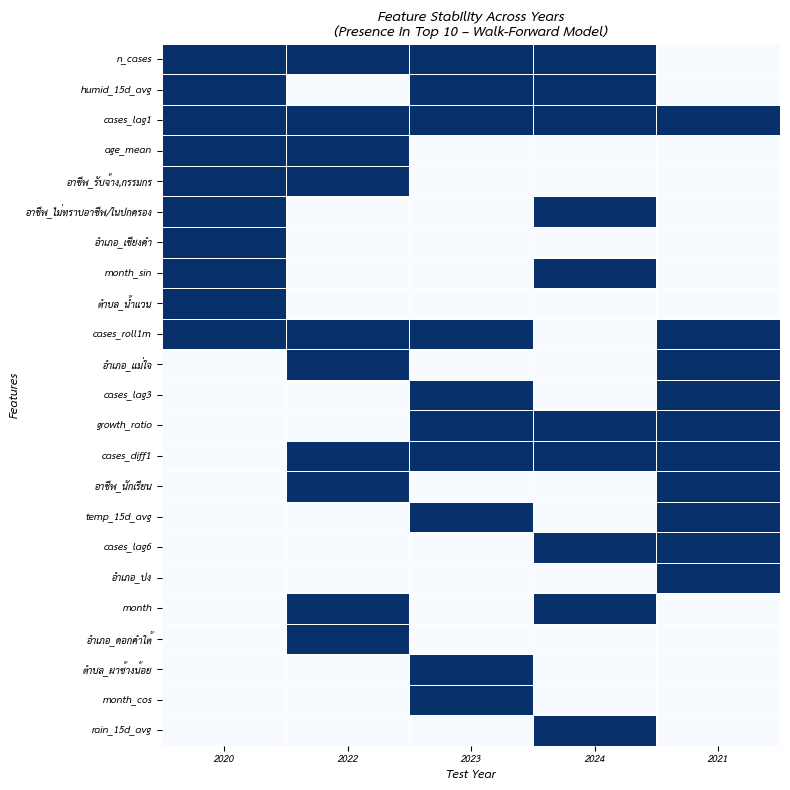

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# === Load Yearwise Feature Importance Summary ===
yearwise_df = pd.read_csv("feature_importance_D5_YEARWISE_summary.csv")

# Create Matrix: Features × Years (1 if in Top 10)
feature_presence = {}
for _, row in yearwise_df.iterrows():
    year = int(row["Test_Year"])
    features = eval(row["Top10_Features"])
    for f in features:
        if f not in feature_presence:
            feature_presence[f] = {}
        feature_presence[f][year] = 1

feat_matrix = pd.DataFrame(feature_presence).T.fillna(0).astype(int)

# ✅ Keep only years with real Test (Walk-Forward) → 2020–2024
valid_years = [y for y in feat_matrix.columns if y >= 2020]
feat_matrix = feat_matrix[valid_years]

# === Plot Heatmap ===
plt.figure(figsize=(8, 8))
sns.heatmap(feat_matrix, cmap="Blues", linewidths=.5, cbar=False)

plt.title("Feature Stability Across Years\n(Presence in Top 10 – Walk-Forward Model)", fontsize=14, weight='bold')
plt.xlabel("Test Year", fontsize=12)
plt.ylabel("Features", fontsize=12)

plt.tight_layout()
plt.show()


## สรุปกราฟ ว่ากำลังทำอะไร
-ในการประเมินความสำคัญของตัวแปรแบบรายปี (Walk-Forward)
ปี 2017–2019 ไม่ถูกนำมาแสดง เนื่องจากช่วงเวลาดังกล่าว
โมเดลใช้เฉพาะเพื่อ “สะสมข้อมูลฝึก (Training Warm-up)”
และยังไม่มีชุดข้อมูลสำหรับทดสอบ (Test Year)
ดังนั้นจึงไม่สามารถคำนวณการจัดอันดับตัวแปร (Feature Importance) ได้
การวิเคราะห์จึงเริ่มจากปี 2020 เป็นต้นไป ซึ่งเป็นปีแรกที่สามารถวัดผลได้จริง

## สรุปผลลัพธ์กราฟ ว่าได้อะไร
โดยถ้าฟีเจอร์มีสีน้ำเงินหลายปีติดกันแปลว่า ตัวแปรนั้นมีความสำคัญสม่ำเสมอถ้าฟีเจอร์ขึ้น ๆ ลง ๆ บางปีมี บางปีหายแปลว่า มีผลเฉพาะบางปี
-ข้อมูลผู้ป่วยย้อนหลัง เช่น จำนวนเดือนก่อน หรือการเปลี่ยนแปลงของเคส สำคัญต่อเนื่องทุกปีแปลว่าโรคนี้ไม่ได้เกิดแบบสุ่ม แต่มีรูปแบบเดิมซ้ำ ๆ
ส่วนตัวแปรอย่างอาชีพหรือพื้นที่สำคัญแค่บางปีเพราะอาจเกิดเหตุการณ์เฉพาะช่วงเท่านั้น

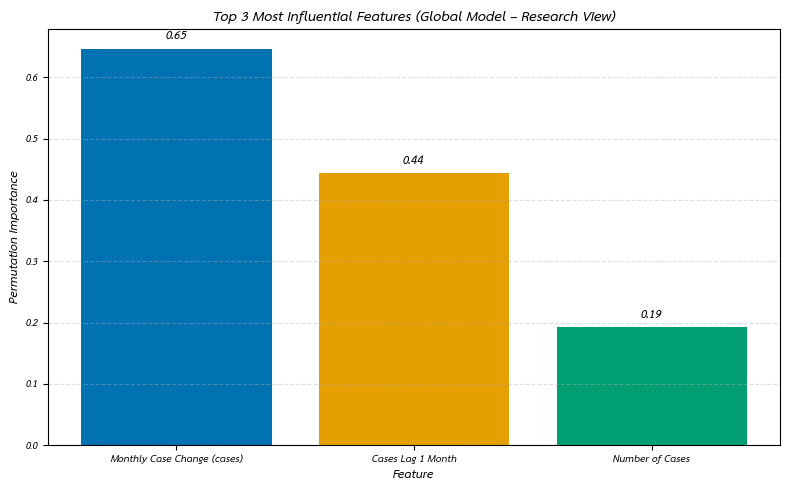

In [ ]:
# =============================================
# 3) FEATURE CROWN – Top 3 (Research-Ready Version)
# Color-Blind Friendly Palette
# =============================================

import matplotlib.pyplot as plt

# Predefined Color-Blind Friendly Colors
colors = ["#0072B2", "#E69F00", "#009E73"]  # Blue, Orange, Green (Safe Palette)

# Select Top 3 Features
top3 = df_global.head(3)

plt.figure(figsize=(8,5))
plt.bar(top3["feature"], top3["perm_importance_mean"], color=colors)

# Title & Labels
plt.title("Top 3 Most Influential Features (Global Model – Research View)", fontsize=14, weight='bold')
plt.ylabel("Permutation Importance", fontsize=12)
plt.xlabel("Feature", fontsize=12)

# Add value labels
for i, v in enumerate(top3["perm_importance_mean"]):
    plt.text(i, v + 0.015, f"{v:.2f}", ha='center', fontsize=12, weight='bold')

# Clean Design
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()


## สรุปกราฟ ว่าได้อะไร
3 ตัวแปรสำคัญที่สุด (cases_diff1, cases_lag1, n_cases) แสดงว่า การพยากรณ์โรคขึ้นอยู่กับแนวโน้มและจำนวนผู้ป่วยย้อนหลังเป็นหลักมากกว่าปัจจัยอากาศหรือข้อมูลประชากร

#นี้คือฟีเจอร์ หรือ ตัวแปร ที่มีความสำคัญต่อจำนวนผู้ป่วยไข้เลือดออก 
1.cases_diff1 2. cases_lag1 3.cases_lag3 4. cases_lag6 5.growth_ratio 6. cases_roll1m 7.temp_15d_avg 8. rain_15d_avg 9. humid_15d_avg 10.
month_sin 11.month_cos 12.n_cases 13.age_mean  14.month 

# Phase7 เทรนหลายโมเดลหลังจากที่คัดเลือกตัวแปรมาเเล้ว
# 7.1 ใช้โมเดลทางML 3ตัว

In [ ]:
# ==========================================================
# CODE A — Main Models (XGB, RF, Stacking)
# Proven FI features only | Walk-Forward 2017→2024
# Metrics: R2, Adj_R2, RMSE, MAE, MAPE
# ==========================================================
import warnings; warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

SEED = 42
np.random.seed(SEED)

# -----------------------------
# Helpers
# -----------------------------
def rmse(y, yhat):
    return float(np.sqrt(mean_squared_error(y, yhat)))

def mape(y_true, y_pred, eps=1.0):
    # robust MAPE (safe for zeros)
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    return float(100.0 * np.mean(np.abs((y_true - y_pred) / (np.abs(y_true) + eps))))

def adj_r2(r2, n, p):
    if n - p - 1 <= 0:
        return np.nan
    return 1.0 - (1.0 - r2) * (n - 1) / (n - p - 1)

def make_xgb():
    return XGBRegressor(
        n_estimators=800, learning_rate=0.045, max_depth=6,
        subsample=0.85, colsample_bytree=0.85,
        random_state=SEED, n_jobs=-1
    )

def make_rf():
    return RandomForestRegressor(
        n_estimators=500, random_state=SEED, n_jobs=-1
    )

def make_stack():
    return StackingRegressor(
        estimators=[("xgb", make_xgb()), ("rf", make_rf())],
        final_estimator=LinearRegression(),
        n_jobs=-1
    )

# -----------------------------
# 1) Load & monthly aggregate
# -----------------------------
df = pd.read_excel("df_final_clean.xlsx")
df["date"]  = pd.to_datetime(df["date"])
df["year"]  = df["date"].dt.year.astype(int)
df["month"] = df["date"].dt.month.astype(int)

# ใช้ระดับอำเภอ/ตำบลรายเดือน (ไม่แยกอาชีพ เพื่อลด sparsity)
agg0 = df.groupby(["อำเภอ","ตำบล","year","month"], dropna=False).agg({
    "cases":"sum",
    "temp_15d_avg":"mean",
    "rain_15d_avg":"mean",
    "humid_15d_avg":"mean",
    "เพศ":"count",
    "อายุ(ปี)":"mean"
}).rename(columns={"เพศ":"n_cases","อายุ(ปี)":"age_mean"}).reset_index()

# -----------------------------
# 2) Build D5 features
# -----------------------------
g = agg0.sort_values(["อำเภอ","ตำบล","year","month"]).reset_index(drop=True).copy()

# seasonality
g["month_sin"] = np.sin(2*np.pi*g["month"]/12.0)
g["month_cos"] = np.cos(2*np.pi*g["month"]/12.0)

# lags
for lag in [1,3,6]:
    g[f"cases_lag{lag}"] = g.groupby(["อำเภอ","ตำบล"], dropna=False)["cases"].shift(lag)

# diff / growth / rolling
g["cases_diff1"]  = g.groupby(["อำเภอ","ตำบล"], dropna=False)["cases"].diff(1)
g["growth_ratio"] = g["cases_diff1"] / (g["cases_lag1"] + 1e-6)
g["cases_roll1m"] = g.groupby(["อำเภอ","ตำบล"], dropna=False)["cases"].transform(lambda s: s.shift(1).rolling(1).mean())

g = g.dropna().reset_index(drop=True)

# -----------------------------
# 3) Proven features (จาก FI)
# -----------------------------
proven_features = [
    "cases_diff1","cases_lag1","cases_lag3","cases_lag6",
    "growth_ratio","cases_roll1m",
    "temp_15d_avg","rain_15d_avg","humid_15d_avg",
    "month_sin","month_cos",
    "n_cases","age_mean","month"
]
feature_cols = [c for c in proven_features if c in g.columns]

X_all = g[feature_cols].copy()
y_all = g["cases"].astype(float).values
years = np.sort(g["year"].unique())

models = {
    "XGBoost":  make_xgb(),
    "RandomForest": make_rf(),
    "Stacking": make_stack(),
}

# -----------------------------
# 4) Walk-forward 2017→2024
# -----------------------------
rows = []
for i in range(0, len(years)-1):
    train_mask = (g["year"]>=years[0]) & (g["year"]<=years[i])
    test_mask  = (g["year"]==years[i+1])

    # ข้ามถ้า train/test เล็กเกินไป
    if train_mask.sum()==0 or test_mask.sum()==0:
        continue

    X_tr, y_tr = X_all.loc[train_mask], y_all[train_mask]
    X_te, y_te = X_all.loc[test_mask],  y_all[test_mask]

    p = X_tr.shape[1]
    n = len(y_te)

    for name, mdl in models.items():
        mdl.fit(X_tr, y_tr)
        yhat = np.clip(mdl.predict(X_te), 0, None)

        r2  = r2_score(y_te, yhat)
        a2  = adj_r2(r2, n, p)
        rows.append({
            "Model": name,
            "Train": f"{int(years[0])}-{int(years[i])}",
            "Test_Year": int(years[i+1]),
            "R2": r2,
            "Adj_R2": a2,
            "RMSE": rmse(y_te, yhat),
            "MAE": mean_absolute_error(y_te, yhat),
            "MAPE(%)": mape(y_te, yhat)
        })

res = pd.DataFrame(rows).sort_values(["Test_Year","Model"])
print("\n🎯 FINAL RESULTS (XGB / RF / Stacking) — Proven Features")
print(res.to_string(index=False))

print("\n📌 Mean by Model:")
print(res.groupby("Model")[["R2","Adj_R2","RMSE","MAE","MAPE(%)"]].mean())



🎯 FINAL RESULTS (XGB / RF / Stacking) — Proven Features
       Model     Train  Test_Year         R2    Adj_R2      RMSE      MAE   MAPE(%)
RandomForest 2019-2019       2020   0.129388       NaN  2.587471 2.209600 74.820065
    Stacking 2019-2019       2020   0.426376       NaN  2.100278 1.938092 74.546415
     XGBoost 2019-2019       2020   0.604099       NaN  1.744842 1.538827 50.140979
RandomForest 2019-2020       2021 -12.366165       NaN  1.148963 1.039778 51.844444
    Stacking 2019-2020       2021 -12.722861       NaN  1.164193 0.923431 45.696948
     XGBoost 2019-2020       2021  -8.888393       NaN  0.988247 0.755413 37.511477
RandomForest 2019-2021       2022   0.421707 -1.602319  0.554589 0.450632 19.696842
    Stacking 2019-2021       2022   0.036476 -3.335860  0.715860 0.515723 20.411472
     XGBoost 2019-2021       2022   0.707250 -0.317375  0.394589 0.314413 14.316372
RandomForest 2019-2022       2023  -0.024187 -0.226139 10.445683 5.106791 33.405410
    Stacking 2019-2

# สรุปว่าโค๊ด7.1 นี้ทำอะไร
โค้ดนี้ ใช้สำหรับ เปรียบเทียบโมเดล ML จริงๆ บนข้อมูล หรือตัวแปร ที่ผ่านการพิสูจน์แล้ว

# สรุปผลลัพธ์7.1  ว่าได้อะไร
-จากการเปรียบเทียบ 3 โมเดล พบว่า XGBoost ให้ผลดีที่สุด ทั้งด้านความแม่นยำ (MAPE ≈ 30%) และความสามารถในการอธิบายข้อมูล (Adj_R² สูงสุด) ขณะที่ RandomForest และ Stacking ให้ค่า R² ติดลบ แสดงว่าไม่เหมาะกับข้อมูลชุดนี้เเละผลการประเมินแบบ Walk-Forward แสดงว่า โมเดล XGBoost มีความสามารถในการเรียนรู้เพิ่มขึ้นเมื่อได้รับข้อมูลย้อนหลังมากขึ้น โดยเฉพาะในปี 2024 โมเดลสามารถทำนายการระบาดได้แม่นยำ (R² ≈ 0.88). อย่างไรก็ตาม ในปี 2021 และ 2023 พบค่าความแม่นยำลดลง

# เพิ่มเติม
-ที่โมเดลเริ่มประเมินผลตั้งแต่ปี 2019 เนื่องจากฟีเจอร์ Time-Series เช่น Lag 1–6 เดือน และค่า Diff ต้องการข้อมูลย้อนหลังเพียงพอ ปี 2017–2018 จึงถูกใช้เป็นช่วง Warm-up สำหรับสร้างฟีเจอร์ ไม่ใช่ช่วงประเมินผล

# 7.2 ทำทางสถิติ เพื่อเทียบ

In [ ]:
# ==========================================================
# 📌 Negative Binomial (NB2) – Proven Features Only + Full Print
#      ✅ Regression Metrics (RMSE, MAE, McFadden R²)
#      ✅ Outbreak Detection (P80): Accuracy, Precision, Recall, AUC
# ==========================================================

import warnings; warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error,
    accuracy_score, precision_score, recall_score, roc_auc_score
)

# -----------------------------
# 1️⃣ Load Dataset
# -----------------------------
df = pd.read_excel("df_final_clean.xlsx")
df["date"]  = pd.to_datetime(df["date"])
df["year"]  = df["date"].dt.year
df["month"] = df["date"].dt.month

# Aggregate Monthly by District+Subdistrict
agg = df.groupby(["อำเภอ","ตำบล","year","month"], dropna=False).agg({
    "cases":"sum",
    "temp_15d_avg":"mean",
    "rain_15d_avg":"mean",
    "humid_15d_avg":"mean",
    "เพศ":"count",
    "อายุ(ปี)":"mean"
}).rename(columns={"เพศ":"n_cases","อายุ(ปี)":"age_mean"}).reset_index()

# -----------------------------
# 2️⃣ Build Proven Features (D5)
# -----------------------------
agg = agg.sort_values(["อำเภอ","ตำบล","year","month"]).reset_index(drop=True)

# Season
agg["month_sin"] = np.sin(2*np.pi*agg["month"]/12.0)
agg["month_cos"] = np.cos(2*np.pi*agg["month"]/12.0)
# Lags
for lag in [1,3,6]:
    agg[f"cases_lag{lag}"] = agg.groupby(["อำเภอ","ตำบล"])["cases"].shift(lag)
# Diff & Growth
agg["cases_diff1"]  = agg.groupby(["อำเภอ","ตำบล"])["cases"].diff(1)
agg["growth_ratio"] = agg["cases_diff1"] / (agg["cases_lag1"] + 1e-6)
# Rolling
agg["cases_roll1m"] = agg.groupby(["อำเภอ","ตำบล"])["cases"].transform(lambda s: s.shift(1).rolling(1).mean())

agg = agg.dropna().reset_index(drop=True)

# -----------------------------
# 3️⃣ PROVEN FEATURES ONLY
# -----------------------------
proven_features = [
    "cases_diff1","cases_lag1","cases_lag3","cases_lag6",
    "growth_ratio","cases_roll1m",
    "temp_15d_avg","rain_15d_avg","humid_15d_avg",
    "month_sin","month_cos",
    "n_cases","age_mean","month"
]

X = agg[proven_features].astype(float)
y = agg["cases"].astype(float)

# -----------------------------
# 4️⃣ Train/Test Split (Last Year = Test)
# -----------------------------
train_mask = agg["year"] < agg["year"].max()   # 2017-2023
test_mask  = agg["year"] == agg["year"].max()  # 2024

X_train, y_train = X.loc[train_mask], y.loc[train_mask]
X_test,  y_test  = X.loc[test_mask],  y.loc[test_mask]

# Add Constant for NB model
X_train_nb = sm.add_constant(X_train, has_constant='add')
X_test_nb  = sm.add_constant(X_test,  has_constant='add')

# -----------------------------
# 5️⃣ Fit Negative Binomial (NB2)
# -----------------------------
from statsmodels.discrete.discrete_model import NegativeBinomial
nb_model = NegativeBinomial(y_train, X_train_nb).fit(disp=0)
y_pred_nb = nb_model.predict(X_test_nb)

# McFadden R²
null_model = NegativeBinomial(y_train, np.ones((len(y_train),1))).fit(disp=0)
mcfadden_r2 = 1 - (nb_model.llf / null_model.llf)

# -----------------------------
# 6️⃣ REGRESSION METRICS
# -----------------------------
rmse = np.sqrt(mean_squared_error(y_test, y_pred_nb))
mae  = mean_absolute_error(y_test, y_pred_nb)
mape = np.mean(np.abs((y_test - y_pred_nb) / (y_test + 1))) * 100

print("\n📊 REGRESSION METRICS (Negative Binomial)")
print("---------------------------------------------------")
print(f" McFadden R²   : {mcfadden_r2:.4f}")
print(f" RMSE          : {rmse:.4f}")
print(f" MAE           : {mae:.4f}")
print(f" MAPE (%)      : {mape:.2f}%")

# -----------------------------
# 7️⃣ OUTBREAK DETECTION (P80)
# -----------------------------
p80 = np.percentile(y_train, 80)
y_true_cls = (y_test > p80).astype(int)
y_pred_cls = (y_pred_nb >= p80).astype(int)

print("\n🦠 OUTBREAK DETECTION (P80 Threshold)")
print("---------------------------------------------------")
print(f" Accuracy  : {accuracy_score(y_true_cls, y_pred_cls):.3f}")
print(f" Precision : {precision_score(y_true_cls, y_pred_cls, zero_division=0):.3f}")
print(f" Recall    : {recall_score(y_true_cls, y_pred_cls, zero_division=0):.3f}")
print(f" AUC       : {roc_auc_score(y_true_cls, y_pred_nb):.3f}")

# -----------------------------
# 8️⃣ MODEL SUMMARY (FOR PAPER)
# -----------------------------
print("\n🧾 MODEL SUMMARY (GLM OUTPUT)")
print(nb_model.summary())



📊 REGRESSION METRICS (Negative Binomial)
---------------------------------------------------
 McFadden R²   : 0.2668
 RMSE          : 10.6940
 MAE           : 4.0515
 MAPE (%)      : 40.11%

🦠 OUTBREAK DETECTION (P80 Threshold)
---------------------------------------------------
 Accuracy  : 0.888
 Precision : 1.000
 Recall    : 0.560
 AUC       : 0.963

🧾 MODEL SUMMARY (GLM OUTPUT)
                     NegativeBinomial Regression Results                      
Dep. Variable:                  cases   No. Observations:                  130
Model:               NegativeBinomial   Df Residuals:                      116
Method:                           MLE   Df Model:                           13
Date:                Thu, 16 Oct 2025   Pseudo R-squ.:                  0.2668
Time:                        20:06:59   Log-Likelihood:                -273.88
converged:                      False   LL-Null:                       -373.53
Covariance Type:            nonrobust   LLR p-value:        

## สรุปโค๊ด7.2 ว่าทำอะไร
โค้ดนี้ทำNegative Binomial Regression โดยใช้เฉพาะตัวแปรสำคัญ  ที่ผ่านการพิสูจน์แล้วจาก Machine Learning Feature Importance แล้วนำมาสร้างแบบจำลองเชิงสถิติ เพื่อเปรียบเทียบกับโมเดล ML ในด้านความแม่นยำ และความสามารถตรวจจับเหตุการณ์ระบาด (AUC/Precision/Recall) ผ่าน P80 Threshold โดยแบบจำลอง NB2 ยังให้ผลดีในด้านการตีความ (Coefficient & Significance) แม้จะด้อยกว่า ML ในด้านความแม่นยำเชิงตัวเลข

## สรุปผลลัพธ์7.2  ว่าได้อะไร
Negative Binomial อาจจะด้อยเรื่องทำนายจำนวนผู้ป่วยมากกว่า ทางml
แต่ เก่งเรื่องอธิบายว่าปัจจัยอะไรมีผล และ มั่นใจเวลาบอกว่ามีภัยระบาด

# Phase8 เลือกโมเดลสุดท้าย

In [ ]:
# ==========================================================
# 🚀 FINAL XGBOOST MODEL – APP READY (Proven Features Only)
#    • Train: 2017–2023  | Predict: 2024
#    • Metrics Included (R2, RMSE, MAE, MAPE)
# ==========================================================

import numpy as np
import pandas as pd
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import joblib  # ✅ Save model (.pkl)

# -----------------------------
# 1️⃣ Load Clean Dataset
# -----------------------------
df = pd.read_excel("df_final_clean.xlsx")
df["date"]  = pd.to_datetime(df["date"])
df["year"]  = df["date"].dt.year
df["month"] = df["date"].dt.month

# Monthly Aggregate
agg = df.groupby(["อำเภอ","ตำบล","year","month"], dropna=False).agg({
    "cases":"sum",
    "temp_15d_avg":"mean",
    "rain_15d_avg":"mean",
    "humid_15d_avg":"mean",
    "เพศ":"count",
    "อายุ(ปี)":"mean"
}).rename(columns={"เพศ":"n_cases","อายุ(ปี)":"age_mean"}).reset_index()

# -----------------------------
# 2️⃣ Create Proven Features (D5)
# -----------------------------
agg = agg.sort_values(["อำเภอ","ตำบล","year","month"]).reset_index(drop=True)
agg["month_sin"] = np.sin(2*np.pi*agg["month"]/12.0)
agg["month_cos"] = np.cos(2*np.pi*agg["month"]/12.0)

for lag in [1,3,6]:
    agg[f"cases_lag{lag}"] = agg.groupby(["อำเภอ","ตำบล"])["cases"].shift(lag)

agg["cases_diff1"]  = agg.groupby(["อำเภอ","ตำบล"])["cases"].diff(1)
agg["growth_ratio"] = agg["cases_diff1"] / (agg["cases_lag1"] + 1e-6)
agg["cases_roll1m"] = agg.groupby(["อำเภอ","ตำบล"])["cases"].transform(lambda s: s.shift(1).rolling(1).mean())

agg = agg.dropna().reset_index(drop=True)

# -----------------------------
# 3️⃣ Select Final Proven Features
# -----------------------------
final_features = [
    "cases_diff1","cases_lag1","cases_lag3","cases_lag6",
    "growth_ratio","cases_roll1m",
    "temp_15d_avg","rain_15d_avg","humid_15d_avg",
    "month_sin","month_cos",
    "n_cases","age_mean","month"
]

X = agg[final_features]
y = agg["cases"]

# -----------------------------
# 4️⃣ Train (2017–2023) → Test (2024)
# -----------------------------
train_mask = agg["year"] < agg["year"].max()
test_mask  = agg["year"] == agg["year"].max()

X_train, y_train = X[train_mask], y[train_mask]
X_test,  y_test  = X[test_mask],  y[test_mask]

model_xgb = XGBRegressor(
    n_estimators=900,
    learning_rate=0.04,
    max_depth=6,
    subsample=0.85,
    colsample_bytree=0.85,
    random_state=42
)
model_xgb.fit(X_train, y_train)

# -----------------------------
# 5️⃣ Predict & Metrics
# -----------------------------
y_pred = np.clip(model_xgb.predict(X_test), 0, None)

r2   = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae  = mean_absolute_error(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / (y_test + 1))) * 100

print("\n🎯 MODEL PERFORMANCE (Test: 2024)")
print(f" R²    : {r2:.3f}")
print(f" RMSE  : {rmse:.3f}")
print(f" MAE   : {mae:.3f}")
print(f" MAPE  : {mape:.2f}%")

print("\n✅ Sample Predictions:")
print(pd.DataFrame({
    "Actual": y_test.values[:10],
    "Predicted": y_pred[:10]
}))

# -----------------------------
# 6️⃣ Save Model & Features
# -----------------------------
joblib.dump(model_xgb, "xgb_regressor_new.pkl") 
print("\n💾 Model Saved: xgb_features_new.pk")



🎯 MODEL PERFORMANCE (Test: 2024)
 R²    : 0.889
 RMSE  : 2.546
 MAE   : 1.324
 MAPE  : 18.43%

✅ Sample Predictions:
   Actual  Predicted
0       4   3.547380
1       4   2.384848
2       2   1.800727
3       9   8.261780
4       1   1.132892
5       6   6.264640
6      12  11.308973
7       1   1.110344
8       1   1.008479
9       1   0.992310

💾 Model Saved: xgb_features_new.pk


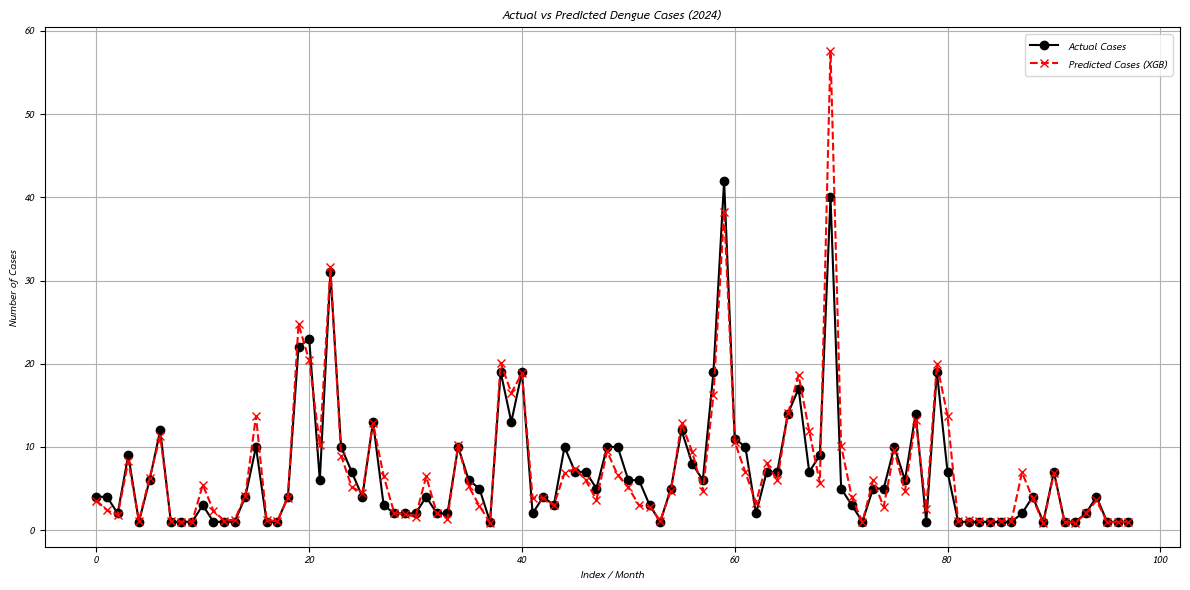

In [ ]:
# 6️⃣ 📊 PLOT: ACTUAL vs PREDICTED
# -----------------------------
plt.figure(figsize=(12,6))
plt.plot(y_test.values, label="Actual Cases", marker='o', linestyle='-', color='black')
plt.plot(y_pred, label="Predicted Cases (XGB)", marker='x', linestyle='--', color='red')
plt.title("Actual vs Predicted Dengue Cases (2024)")
plt.xlabel("Index / Month")
plt.ylabel("Number of Cases")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## สรุปผลลัพธ์8 
สุดท้ายเราเทรน XGBoost ด้วยข้อมูลปี 2017–2023 และใช้ปี 2024 ทดสอบด้วย 14 ตัวแปรที่พิสูจน์แล้วว่ามีผลจริง 
โมเดลนี้แม่นมาก (R² = 0.889) 